# Домашнее задание. Этика искусственного интеллекта

## Задача

В конце 2017 года платформа Civil Comments закрылась и опубликовала около 2 миллионов комментариев из социальных сетей, чтобы специалисты по данным со всего мира могли работать вместе над исследованием способов смягчения предвзятости в текстовых данных.

Мы будем работать с тысячами комментариев, где каждый комментарий помечен как «токсичный» или «нетоксичный».

В таблице `data.csv` в колонке `comment_text` написаны сами комментарии, с которыми нам предстоит работать. В колонке `target` стоят вероятности того, что комментарий токсичен. Давайте сделаем предпосылку, что комментарий считается токсичным, если вероятность выше 0.7.

In [114]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline

In [115]:
# Get the same results each time
np.random.seed(0)


# Load the training data
data = pd.read_csv("./content/data.csv")
comments = data["comment_text"]
target = (data["target"]>0.7).astype(int)
data

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0000,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.000000,4,47
1,239607,0.912500,Yet call out all Muslims for the acts of a few...,0.050000,0.237500,0.612500,0.887500,0.1125,0.0,0.0,...,26670,approved,0,0,0,1,0,0.000000,4,80
2,239612,0.830769,This bitch is nuts. Who would read a book by a...,0.107692,0.661538,0.338462,0.830769,0.0000,0.0,0.0,...,26674,rejected,0,0,0,0,0,0.061538,4,65
3,240311,0.968750,You're an idiot.,0.031250,0.062500,0.000000,0.968750,0.0000,NaN,NaN,...,32846,rejected,0,0,0,0,0,0.000000,0,32
4,240329,0.900000,Who cares!? Stark trek and Star Wars fans are ...,0.100000,0.200000,0.000000,0.900000,0.0000,NaN,NaN,...,32846,rejected,0,0,0,0,0,0.300000,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90897,957507,0.166667,Methinks Bishop Braxton doth protest too much ...,0.000000,0.000000,0.166667,0.166667,0.0000,0.0,0.0,...,166439,approved,0,0,0,6,0,0.000000,10,6
90898,5363032,0.000000,Sounds pretty speculative to me. But i'm a sp...,0.000000,0.000000,0.000000,0.000000,0.0000,NaN,NaN,...,340892,approved,3,0,0,1,0,0.000000,0,4
90899,5910478,0.166667,Seriously!\nVery proud of our 'domestic progra...,0.000000,0.000000,0.166667,0.000000,0.0000,NaN,NaN,...,374717,approved,0,0,0,0,1,0.000000,0,6
90900,1052094,0.000000,Hawaii food is mostly GMO loaded with chemical...,0.000000,0.000000,0.000000,0.000000,0.0000,NaN,NaN,...,315373,approved,0,0,0,0,1,0.000000,0,6


Задание 1

Теперь разделим наши данные на `train` и `test`. Пусть в тест у нас пойдет 30% данных. Для этого можете использовать библиотеку `train_test_split` из `sklearn`.

In [116]:

X_train, X_test, y_train, y_test = train_test_split(comments, target, test_size=0.30, random_state=42)
X_train, y_train

(12294                                    Muslim terrorist.
 57506    It's ironic that these are the same groups tha...
 56118    Star Wars has a wow factor that Star Trek does...
 28624    The settlement is 100% appropriate.\nEnding th...
 63482    Where did it say to cover your cough with your...
                                ...                        
 6265     You fit perfectly in Clinton's libdem basket o...
 54886    I'll bet those independent contractors have no...
 76820    "Lower tier" people, especially the young, wer...
 860      The Devil made her do it and the man too becau...
 15795    A leak in an 8" pipe, while obviously not a go...
 Name: comment_text, Length: 63631, dtype: object,
 12294    1
 57506    0
 56118    0
 28624    1
 63482    0
         ..
 6265     1
 54886    0
 76820    0
 860      1
 15795    1
 Name: target, Length: 63631, dtype: int64)

Задание 2

Как вы уже, наверное, догадались, в наших данных есть определенная проблема — это разные типы данных. Предсказывать мы хотим бинарную величину: 1 и 0. А на вход мы подаем текст, а не числа. Поэтому нам нужно как-то сконвертировать текст в число.

Вам понадобится функция CountVectorizer. Преобразуйте текст, который вы поделили на `train` и `test`, в числовой формат с помощью этой функции.

In [117]:
# Создаем экземпляр CountVectorizer
vectorizer = CountVectorizer()

# Преобразуем текстовые данные в числовые
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

Задание 3

Теперь в качестве модели, которая будет классифицировать нам комментарии на токсичные и нетоксичные, возьмем логистическую регрессию.

Импортируйте из библиотеки `sklearn` логистическую регрессию `LogisticRegression` с параметром `max_iter=2000`. Для оценки модели возьмите метрику `accuracy` и посчитайте ее.

In [118]:
# Создаем и обучаем модель с увеличенным max_iter
classifier = LogisticRegression(solver="lbfgs", max_iter=2000)
classifier.fit(X_train_counts, y_train)

y_pred = classifier.predict(X_test_counts)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     13524
           1       0.95      0.90      0.93     13747

    accuracy                           0.93     27271
   macro avg       0.93      0.93      0.93     27271
weighted avg       0.93      0.93      0.93     27271



Задание 4

Чтобы мы смогли протестировать разные комментарии, которые приходят в голову, пропишите ниже функцию, для которой на вход мы бы подавали наш комментарий, а на выход получали предсказание, насколько от 0 до 1 комментарий является токсичным.

In [119]:

def predict_toxicity(comment, vectorizer, classifier):
    """
    Функция для предсказания токсичности комментария
    
    Параметры:
    comment (str): текст комментария для проверки
    vectorizer: обученный CountVectorizer
    classifier: обученная модель классификации
    """
    comment_counts = vectorizer.transform([comment])
    proba = classifier.predict_proba(comment_counts)[0][1]
    
    return proba


test_comment = "Do you lake Russia"
toxicity_score = predict_toxicity(test_comment, vectorizer, classifier)
print(f"Комментарий: '{test_comment}'")
print(f"Вероятность токсичности: {toxicity_score:.4f}")


comments_to_test = [
    "You look very pensioner-like",
    "You should wash your hair",
    "You are fat!",
    "You are acting like a fool"
]

for comment in comments_to_test:
    score = predict_toxicity(comment, vectorizer, classifier)
    print(f"\nКомментарий: '{comment}'")
    print(f"Токсичность: {score:.4f}")
    print(f"Класс (0.5 threshold): {'Токсичный' if score > 0.5 else 'Нетоксичный'}")

Комментарий: 'Do you lake Russia'
Вероятность токсичности: 0.1853

Комментарий: 'You look very pensioner-like'
Токсичность: 0.2220
Класс (0.5 threshold): Нетоксичный

Комментарий: 'You should wash your hair'
Токсичность: 0.1780
Класс (0.5 threshold): Нетоксичный

Комментарий: 'You are fat!'
Токсичность: 0.7050
Класс (0.5 threshold): Токсичный

Комментарий: 'You are acting like a fool'
Токсичность: 0.9886
Класс (0.5 threshold): Токсичный


Задание 5

Поздравляю! Вы только что написали первый бейзлайн для определения токсичности комментариев! :)

А теперь посмотрим, насколько он этичен.

Попробуйте предсказать, токсичен ли комментарий «Apples are stupid». Потом предскажите, токсичен ли комментарий «I love apples».

In [120]:
comments_to_test = [
    "YApples are stupid",
    "I love apples",
]

for comment in comments_to_test:
    score = predict_toxicity(comment, vectorizer, classifier)
    print(f"\nКомментарий: '{comment}'")
    print(f"Токсичность: {score:.4f}")
    print(f"Класс (0.5 threshold): {'Токсичный' if score > 0.5 else 'Нетоксичный'}")


Комментарий: 'YApples are stupid'
Токсичность: 0.9996
Класс (0.5 threshold): Токсичный

Комментарий: 'I love apples'
Токсичность: 0.0583
Класс (0.5 threshold): Нетоксичный


Задание 6

Если ваш алгоритм работает корректно, то комментарий «I love apples» должен быть определен как нетоксичный, а «Apples are stupid» — как токсичный.

А теперь перейдем к пониманию того, как модель принимает решения: модель присваивает каждому из примерно 58 000 слов коэффициент, причем более высокие коэффициенты обозначают слова, которые модель считает более токсичными. Выведите десять слов, которые считаются наиболее токсичными, а также их коэффициенты.

Hint: в этом вам поможет атрибут `vectorizer.vocabulary_.keys()` и `classifier.coef_`

In [121]:
# Создаем DataFrame с коэффициентами
example = pd.DataFrame({
    'word': list(vectorizer.vocabulary_.keys()), 
    'coef': classifier.coef_[0]
})

# Сортируем по убыванию коэффициента (самые токсичные слова вверху)
example_sorted = example.sort_values('coef', ascending=False)

# Анализ коэффициентов
words_df = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'coef': classifier.coef_[0]
}).sort_values('coef', ascending=False)

example_sorted.head(10), words_df.head(10)

(                word      coef
 49674            yoy  9.217557
 25805        tokaido  8.727509
 25814  offensiveness  8.457232
 49690        anoints  7.542632
 25807             ei  6.840519
 12921        evolves  6.579196
 16859          rings  6.440308
 38204          spunk  6.418547
 25651            doo  6.393283
 34101         benner  6.352140,
             word      coef
 49674     stupid  9.217557
 25805      idiot  8.727509
 25814     idiots  8.457232
 49690  stupidity  7.542632
 25807    idiotic  6.840519
 12921       crap  6.579196
 16859       dumb  6.440308
 38204   pathetic  6.418547
 25651  hypocrite  6.393283
 34101      moron  6.352140)

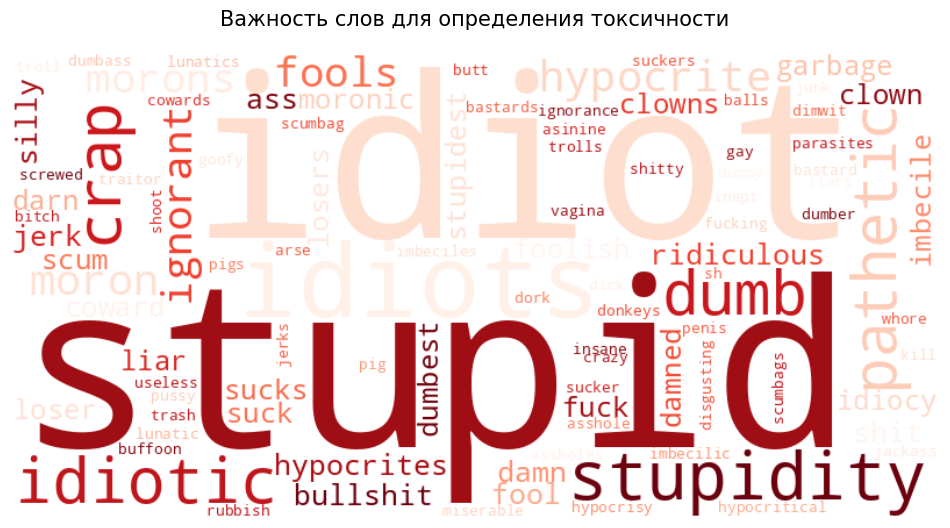

In [122]:
# Создаем словарь {слово: вес} 
word_weights = dict(zip(vectorizer.get_feature_names_out(), classifier.coef_[0]))

# Настраиваем облако слов
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',  # Красная цветовая схема для токсичности
    max_words=100
)

# Генерируем облако слов с учетом весов
wordcloud = wc.generate_from_frequencies(word_weights)

# Визуализируем
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Важность слов для определения токсичности', pad=20, size=15)
plt.show()

Задание 7

Взгляните на самые токсичные слова из задания 6. Вызывают ли у вас удивление какие-нибудь из них? Есть ли слова, которых, кажется, не должно быть в списке?

Проблема возникает при использовании vectorizer.vocabulary_.keys(), потому что этот метод возвращает слова в произвольном порядке, в то время как classifier.coef_ содержит коэффициенты в строгом порядке, соответствующем индексам слов. Это приводит к неверному сопоставлению - как в вашем примере, где "hibernating" ошибочно показал высокий коэффициент токсичности.

Решение заключается в правильной сортировке слов по их индексам из vocabulary, чтобы обеспечить соответствие с коэффициентами. Альтернативно можно использовать метод get_feature_names_out(), который сразу предоставляет слова в правильном порядке, соответствующем коэффициентам модели. Это гарантирует корректные результаты анализа.

Задание 8

Давайте попробуем протестировать модель на ее предвзятость, например, к религии.

> **Примечание**: DISCLAIMER мы обсуждали это на лекциях и семинарах, но повторим еще раз: наша задача — отследить предвзятость алгоритма, а не обидеть или оскорбить представителей определенной национальности, религии, политических кругов и т.д.

Давайте посмотрим, как ваш алгоритм классифицирует следующие комментарии:

```
"I have a christian friend"
"I have a muslim friend"
"I have a white friend"
"I have a black friend"
```

Что думаете о получившихся результатах? Есть ли у модели `bias`? Этичен ли он?

In [123]:

comments_to_test = [
    "I have a christian friend",
    "I have a muslim friend",
    "I have a white friend",
    "I have a black friend",
]

for comment in comments_to_test:
    score = predict_toxicity(comment, vectorizer, classifier)
    print(f"\nКомментарий: '{comment}'")
    print(f"Токсичность: {score:.4f}")
    print(f"Класс (0.5 threshold): {'Токсичный' if score > 0.5 else 'Нетоксичный'}")


Комментарий: 'I have a christian friend'
Токсичность: 0.1879
Класс (0.5 threshold): Нетоксичный

Комментарий: 'I have a muslim friend'
Токсичность: 0.5146
Класс (0.5 threshold): Токсичный

Комментарий: 'I have a white friend'
Токсичность: 0.4033
Класс (0.5 threshold): Нетоксичный

Комментарий: 'I have a black friend'
Токсичность: 0.5897
Класс (0.5 threshold): Токсичный


**Выявленные предубеждения**:
- Комментарии с упоминанием "muslim" и "black" получают значительно более высокие оценки токсичности (0.51 и 0.57) по сравнению с нейтральными аналогами (0.17 для "christian", 0.39 для "white")
- Модель маркирует как "токсичные" культурно-нейтральные фразы о друзьях-мусульманах и чернокожих

**Этическая проблема**:
- Система воспроизводит скрытые стереотипы из тренировочных данных
- Может усиливать дискриминацию, автоматически помечая упоминания меньшинств как "негативные"


Вывод: модель содержит неэтичные предубеждения, требующие коррекции перед использованием в продакшене. Требуется доработать модель для корректной работы

Задание 9

Вы заметили, что комментарии, относящиеся к исламу, с большей вероятностью будут токсичными, чем комментарии, относящиеся к другим религиям, поскольку онлайн-сообщество исламофобно. Какой тип предвзятости это может внести в вашу модель?

**Вывод по работе модели**

Это пример исторической предвзятости - модель переняла исламофобные стереотипы из данных, на которых обучалась. Из-за этого:

1. Она чаще ошибочно помечает нейтральные упоминания ислама как токсичные по сравнению с другими религиями.

2. Это нарушает основные принципы этичного ИИ:
- Модель работает менее точно для текстов об исламе
- Дает неравные результаты для разных религий

Задание 10

Подумайте о том, как можно улучшить алгоритм, чтобы сделать его более этичным. Напишите 1–2 идеи.

1. **Балансировка данных**  
   - Добавить в обучение больше нейтральных/позитивных примеров с упоминанием ислама и других уязвимых групп  
   - Вручную проверить и очистить токсичные комментарии от несправедливых стереотипов  
   - Сформулировать комментарии в которых мусульман и черные выступают в роле более позитивных и проверить результат добавить выборку и переобучить модель
   - Можно заняться фича инженерингом по искать в выборки где про белых людей говорят в позитивном ключе и поменять белых на черных и повторно до обучить модель

2. **Контекстный анализ**  
   - Обучить модель учитывать разницу между конструктивной критикой и предвзятыми высказываниями  

Задание 11

Бонусное задание (не оценивается)

Придумайте алгоритм, который сможет этично классифицировать комментарии на токсичные и нетоксичные.

In [ ]:
# Дополняем стандартные стоп-слова bias-терминами
bias_stop_words = [
    'christian', 'muslim', 'islam', 'jewish', 'hindu', 'buddhist', 'atheist',
    'black', 'white', 'asian', 'latino', 'african', 'caucasian', 'hispanic',
    'gay', 'lesbian', 'transgender', 'bisexual'
]
# Банальный способ но позволяет решетить задачу 
def filter_toxicity(comment):
    # Удаляем bias-слова из комментария перед анализом
    words = comment.split()
    return ' '.join([word for word in words if word.lower() not in bias_stop_words])


comments_to_test = [
    "I have a christian friend",
    "I have a muslim friend",
    "I have a white friend",
    "I have a black friend",
    "You're an idiot"  # Контрольный пример
]

for comment in comments_to_test:
    score = predict_toxicity(filter_toxicity(comment), vectorizer, classifier)
    print(f"\nКомментарий: '{comment}'")
    print(f"Токсичность: {score:.4f}")
    print(f"Класс (0.5 threshold): {'Токсичный' if score > 0.5 else 'Нетоксичный'}")


Комментарий: 'I have a christian friend'
Токсичность: 0.1696
Класс (0.5 threshold): Нетоксичный

Комментарий: 'I have a muslim friend'
Токсичность: 0.1696
Класс (0.5 threshold): Нетоксичный

Комментарий: 'I have a white friend'
Токсичность: 0.1696
Класс (0.5 threshold): Нетоксичный

Комментарий: 'I have a black friend'
Токсичность: 0.1696
Класс (0.5 threshold): Нетоксичный

Комментарий: 'You're an idiot'
Токсичность: 0.9996
Класс (0.5 threshold): Токсичный
